## Importing necessary libs

In [19]:
import matplotlib.pyplot as plt
import pickle
import pathlib
import numpy as np
import pandas as pd
from scipy.stats import anderson
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

## Defining file path

In [20]:
DATA_DIR = pathlib.Path.cwd().parent / 'data'
clean_data_path = DATA_DIR / 'processed' / 'ames_clean.pkl'
print(DATA_DIR)

/home/victor/insper/6-sem/ml/ames_AndreVictor/data


## Opening file with cleaned data

In [21]:
clean_data_path = DATA_DIR / 'processed' / 'ames_clean.pkl'

with open(clean_data_path, 'rb') as file:
    data = pickle.load(file)

## Removing outliers

Despite some outliers were already removed on "02_analysis_and_preprocessing.ipynb", by reading the documentation we found this piece of information:

```There are 5 observations that an instructor may wish to remove from the data set before giving it to students (a plot of SALE PRICE versus GR LIV AREA will indicate them quickly). Three of them are true outliers (Partial Sales that likely don�t represent actual market values) and two of them are simply unusual sales (very large houses priced relatively appropriately). I would recommend removing any houses with more than 4000 square feet from the data set (which eliminates these 5 unusual observations) before assigning it to students.```

So let's check if Prof. Ayres has already removed this outliers highlitghed in the documentation.

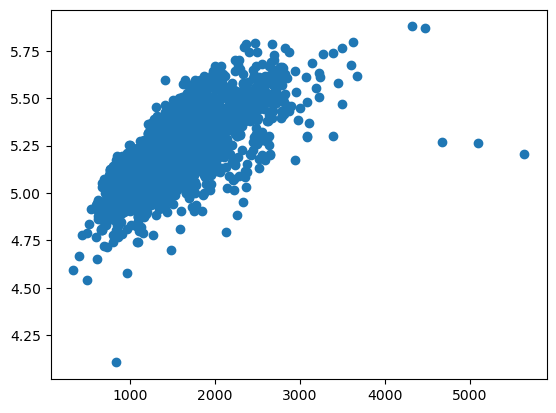

In [22]:
plt.plot(data['Gr.Liv.Area'], data.SalePrice, 'o', alpha=1)
plt.show()


Well, he did not. So let's remove them. 

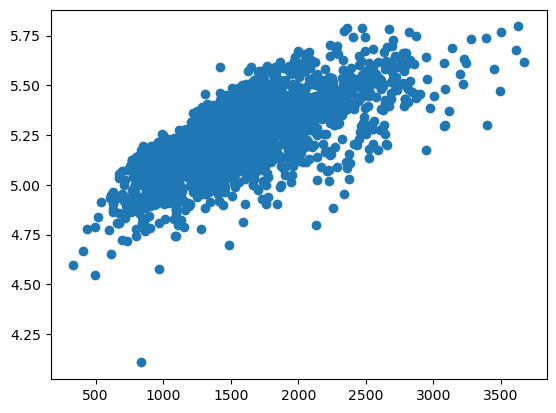

In [23]:
data = data[data['Gr.Liv.Area'] < 4000]

plt.plot(data['Gr.Liv.Area'], data.SalePrice, 'o', alpha=1)
plt.show()

Look's better! Now let's start the data transformation.

## Transforming the data for the model

There are lots of possible data transformations to improve model performance. To understand which ones make sense to AMES dataset, it is necessary to investigate and understand data analysis made in notebook "02_analysis_and_processing.ipynb". One characteristic that stood out from some features was the concentrations to the left in the scatter plots. It may mean that calculating the log of the value can improve correlation with target variable. To check if this is true, it is necessary to select only numerical data. 

In [5]:
numerical_data = data.select_dtypes('number').drop(columns='SalePrice').copy()
numerical_data

,Lot.Frontage,Lot.Area,Mas.Vnr.Area,BsmtFin.SF.1,BsmtFin.SF.2,Bsmt.Unf.SF,Total.Bsmt.SF,X1st.Flr.SF,X2nd.Flr.SF,Low.Qual.Fin.SF,...,Enclosed.Porch,X3Ssn.Porch,Screen.Porch,Pool.Area,Misc.Val,Mo.Sold,Yr.Sold,Garage.Age,Remod.Age,House.Age
0,141.0,31770.0,112.0,639.0,0.0,441.0,1080.0,1656.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.0,2010.0,50.0,50.0,50.0
1,80.0,11622.0,0.0,468.0,144.0,270.0,882.0,896.0,0.0,0.0,...,0.0,0.0,120.0,0.0,0.0,6.0,2010.0,49.0,49.0,49.0
2,81.0,14267.0,108.0,923.0,0.0,406.0,1329.0,1329.0,0.0,0.0,...,0.0,0.0,0.0,0.0,12500.0,6.0,2010.0,52.0,52.0,52.0
3,93.0,11160.0,0.0,1065.0,0.0,1045.0,2110.0,2110.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,2010.0,42.0,42.0,42.0
4,74.0,13830.0,0.0,791.0,0.0,137.0,928.0,928.0,701.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,2010.0,13.0,12.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,37.0,7937.0,0.0,819.0,0.0,184.0,1003.0,1003.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,2006.0,22.0,22.0,22.0
2926,68.0,8885.0,0.0,301.0,324.0,239.0,864.0,902.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,6.0,2006.0,23.0,23.0,23.0
2927,62.0,10441.0,0.0,337.0,0.0,575.0,912.0,970.0,0.0,0.0,...,0.0,0.0,0.0,0.0,700.0,7.0,2006.0,28.0,14.0,14.0
2928,77.0,10010.0,0.0,1071.0,123.0,195.0,1389.0,1389.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,2006.0,31.0,31.0,32.0


Now we can validate our idea. One way to understand if makes sense calculating log values is checking data distribution. "Scipy.stats" has a function named "anderson" that runs a Anderson–Darling hypothesis test that allows checking if data follows a determined distribution. 

### Checking lognormal distribution

In [6]:
for col in numerical_data.columns:
    non_zero_values = data[data[col] != 0]

    anderson_stat, anderson_critical_values, anderson_significance_levels = anderson(np.log(non_zero_values[col]))

    if anderson_stat < anderson_critical_values[2]:  # Using a 5% significance level
        print(f"The data in {col} follows a lognormal distribution.")
    else:
        print(f"The data in {col} does NOT follow a lognormal distribution.")

The data in Lot.Frontage does NOT follow a lognormal distribution.
The data in Lot.Area does NOT follow a lognormal distribution.
The data in Mas.Vnr.Area does NOT follow a lognormal distribution.
The data in BsmtFin.SF.1 does NOT follow a lognormal distribution.
The data in BsmtFin.SF.2 does NOT follow a lognormal distribution.
The data in Bsmt.Unf.SF does NOT follow a lognormal distribution.
The data in Total.Bsmt.SF does NOT follow a lognormal distribution.
The data in X1st.Flr.SF does NOT follow a lognormal distribution.
The data in X2nd.Flr.SF does NOT follow a lognormal distribution.
The data in Low.Qual.Fin.SF does NOT follow a lognormal distribution.
The data in Gr.Liv.Area does NOT follow a lognormal distribution.
The data in Bsmt.Full.Bath does NOT follow a lognormal distribution.
The data in Bsmt.Half.Bath does NOT follow a lognormal distribution.
The data in Full.Bath does NOT follow a lognormal distribution.
The data in Half.Bath does NOT follow a lognormal distribution.
T

That's bad. None of the varaibles have lognormal distribution. So, what else can we do? Hmmm... Why not just calculating the log and comparing correlation of the values with the target?

### Checking log correlation

In [7]:
target = data['SalePrice'].copy()

In [8]:
for column, series in numerical_data.items():
    # Calculate correlation between the two columns
    corr = series.corr(target)

    series = series.loc[series != 0]
    log_series = series.apply(np.log)
    corr_log = log_series.corr(target)
    
    if abs(corr_log) > (abs(corr) + 0.05):
        print("Correlation between", column, "and the target is", corr)
        print("Correlation between log("+column+") and the target is", corr_log)
        print()

Correlation between Lot.Area and the target is 0.2671730653744393
Correlation between log(Lot.Area) and the target is 0.38856797199043147



Correlation between BsmtFin.SF.2 and the target is 0.012288888504329113
Correlation between log(BsmtFin.SF.2) and the target is 0.16732899860234482

Correlation between X2nd.Flr.SF and the target is 0.2803996230200053
Correlation between log(X2nd.Flr.SF) and the target is 0.6563155146778424

Correlation between Low.Qual.Fin.SF and the target is -0.042973068564162255
Correlation between log(Low.Qual.Fin.SF) and the target is 0.19839155340570916

Correlation between Enclosed.Porch and the target is -0.13150907616578927
Correlation between log(Enclosed.Porch) and the target is 0.2219024329127324

Correlation between X3Ssn.Porch and the target is 0.040288336771073616
Correlation between log(X3Ssn.Porch) and the target is 0.1158704329894402

Correlation between Screen.Porch and the target is 0.10833346260732316
Correlation between log(Screen.Porch) and the target is 0.23726247072136608

Correlation between Pool.Area and the target is 0.054858803809843676
Correlation between log(Pool.Area) a

Yyyyaaaaaayyy! Correlation increases on "Lot.Area", "BsmtFin.SF.2", "X2nd.Flr.SF", "Low.Qual.Fin.SF", "Enclosed.Porch", "X3Ssn.Porch", "Screen.Porch", "Pool.Area" and "Misc.Val" when log is calculated.

In [9]:
columns_to_log = ['Lot.Area', 'BsmtFin.SF.2', 'X2nd.Flr.SF', 'Low.Qual.Fin.SF', 'Enclosed.Porch', 'X3Ssn.Porch', 'Screen.Porch', 'Pool.Area', 'Misc.Val']

## Scaling the data

Another great strategy to improve performance on models is to scale the numerical data. This strategy has no effect on models like Decisions Trees, but have a huge impact on linear models like Elastic Net.

Checking boxplot charts, lots of outliers were noticed. If data is scaled by minimum and maximun values, data quality will be impacted because of the effect of outliers. Instead of applying min and max scaling, a better strategy is to apply standard scaler.

# Create data transformation pipeline

In [10]:
num_pipeline = Pipeline([
    ('log_transformer', FunctionTransformer(np.log, validate=True, kw_args={'columns_to_log': columns_to_log})),
    ('std_scaler', StandardScaler()),
])

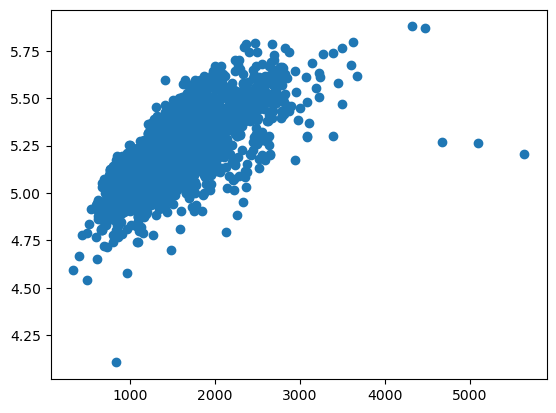